# Import library

In [1]:
!pip install emd
# !pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 KB 654.8 kB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 1.9 MB/s eta 0:00:00a 0:00:01


# Import data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import emd

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...,...
35035,31/12/2018 23:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
35036,31/12/2018 23:15,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
35037,31/12/2018 23:30,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load
35038,31/12/2018 23:45,3.78,3.06,0.11,0.0,77.72,99.96,85500,Weekday,Monday,Light_Load


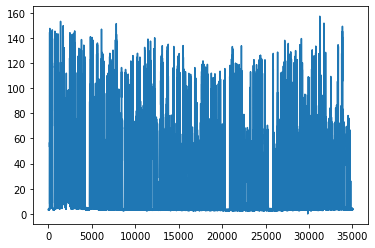

In [3]:
df = pd.read_csv('../input/steel-industry-energy-consumption/Steel_industry_data.csv')
display(df)
load = df['Usage_kWh']
time = np.array(df['date'])
load.plot()
plt.show()

# Cleaning data

In [4]:
#replace 0 value with the minimum value except 0
second_min = min(load[load != 0])
load[load == 0] = second_min
display(load[load == 0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Series([], Name: Usage_kWh, dtype: float64)

# Spliting data (70:30)

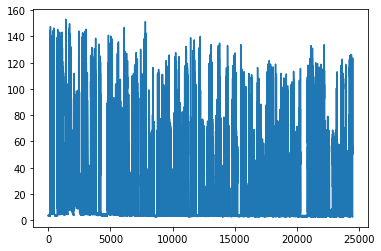

In [5]:
train = load[:int(len(load)*0.7)]
test = load[int(len(load)*0.7):]
plt.plot(train)
plt.show()

# some explanatory data here

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
acf_values = acf(train)
plot_acf(train, lags=100)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=100)
plt.show()

# Preprocess for SVM

In [ ]:
# display(df)
# other_vars = ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor',
#               'Leading_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
# other_vars_df = df[other_vars]
# # display(other_vars_df)
# other_vars_train = other_vars_df[:int(len(load)*0.7)]
# other_vars_test = other_vars_df[int(len(load)*0.7):]
# display(other_vars_train, other_vars_test)


In [6]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
for i in range(1,4):
    df_train["lag{}".format(i)] = df_train["Usage_kWh"].shift(i)
    df_test["lag{}".format(i)] = df_test["Usage_kWh"].shift(i)
df_train['MA_2'] = train.rolling(window = 2).mean()
df_test['MA_2'] = test.rolling(window = 2).mean()

# df_train = pd.merge(df_train, other_vars_train, left_index=True, right_index=True, how = 'outer')
# df_test = pd.merge(df_test, other_vars_test, left_index=True, right_index=True, how = 'outer')

df_train = df_train.fillna(0)
df_train = df_train.drop(columns = ["Usage_kWh"])
df_test = df_test.fillna(0)
df_test = df_test.drop(columns = ["Usage_kWh"])

display(df_train, df_test)

,lag1,lag2,lag3,MA_2
0,0.00,0.00,0.00,0.000
1,3.17,0.00,0.00,3.585
2,4.00,3.17,0.00,3.620
3,3.24,4.00,3.17,3.275
4,3.31,3.24,4.00,3.565
...,...,...,...,...
24523,51.80,78.44,123.55,52.700
24524,53.60,51.80,78.44,51.965
24525,50.33,53.60,51.80,50.670
24526,51.01,50.33,53.60,53.730


,lag1,lag2,lag3,MA_2
24528,0.00,0.00,0.00,0.000
24529,7.31,0.00,0.00,5.870
24530,4.43,7.31,0.00,4.465
24531,4.50,4.43,7.31,4.790
24532,5.08,4.50,4.43,22.665
...,...,...,...,...
35035,3.82,3.67,3.24,3.835
35036,3.85,3.82,3.67,3.795
35037,3.74,3.85,3.82,3.760
35038,3.78,3.74,3.85,3.780


# ARIMA - SVM

In [ ]:
import pmdarima as pm
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

## ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
 
# Build Model
arima = ARIMA(train, order=(1, 1, 1)).fit()
print(arima.summary())

In [ ]:
# plotting
arima_fc = arima.forecast(len(test)) 

# Make as pandas series
fc_series = pd.Series(arima_fc, index = [x for x in range(len(train),len(train)+len(test))])
test_series = pd.Series(test, index = [x for x in range(len(train),len(train)+len(test))])
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(fc_series, label='forecast')
plt.plot(arima.predict(), label = 'fit')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
arima_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
arima_SVR.fit(df_train.values, arima.resid)
arima_SVR_fc = arima_SVR.predict(np.array(df_test))

In [ ]:
# print(arimia_SVR)
plt.plot(arima_SVR_fc+arima_fc)
plt.plot(test)

In [ ]:
RMSE_arima_svm = mean_squared_error(test, arima_SVR_fc+arima_fc)
MAE_arima_svm  =mean_absolute_error(test, arima_SVR_fc+arima_fc)
MAPE_arima_svm = mean_absolute_percentage_error(test, arima_SVR_fc+arima_fc)
print('RMSE = {}'.format(RMSE_arima_svm), '\nMAE = {}'.format(MAE_arima_svm), '\nMAPE = {}'.format(MAPE_arima_svm))

In [ ]:
#test area
plt.plot(arima_SVR_fc[:200]+arima_fc[:200])
plt.plot(test[:200])

# Holt-Winter - SVM

## Holt-Winter

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
holt_winter = HWES(train, seasonal_periods=12, trend = 'add', seasonal='add').fit()
print(holt_winter.summary())

In [ ]:
hw_fc = holt_winter.forecast(len(test)) 

# Make as pandas series
hw_series = pd.Series(hw_fc, index = [x for x in range(len(train),len(train)+len(test))])
test_series = pd.Series(test, index = [x for x in range(len(train),len(train)+len(test))])
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(hw_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
print(holt_winter.predict(len(train)))

In [ ]:
hw_SVR = SVR(kernel = 'rbf', C= 0.5, gamma= 'scale')
hw_SVR.fit(df_train.values, holt_winter.resid)

hw_SVR_fc = hw_SVR.predict(np.array(df_test))
# print(arimia_SVR)

In [ ]:
plt.plot(hw_SVR_fc+hw_fc)
plt.plot(test)

In [ ]:
RMSE_hw_SVR = mean_squared_error(test, hw_SVR_fc+hw)
MAE_hw_SVR  =mean_absolute_error(test, hw_SVR_fc+hw)
MAPE_hw_SVR = mean_absolute_percentage_error(test, hw_SVR_fc+hw)
print('RMSE = {}'.format(RMSE_hw_SVR), '\nMAE = {}'.format(MAE_hw_SVR), '\nMAPE = {}'.format(MAPE_hw_SVR))

# Empirical M Decomposition - SVM

 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

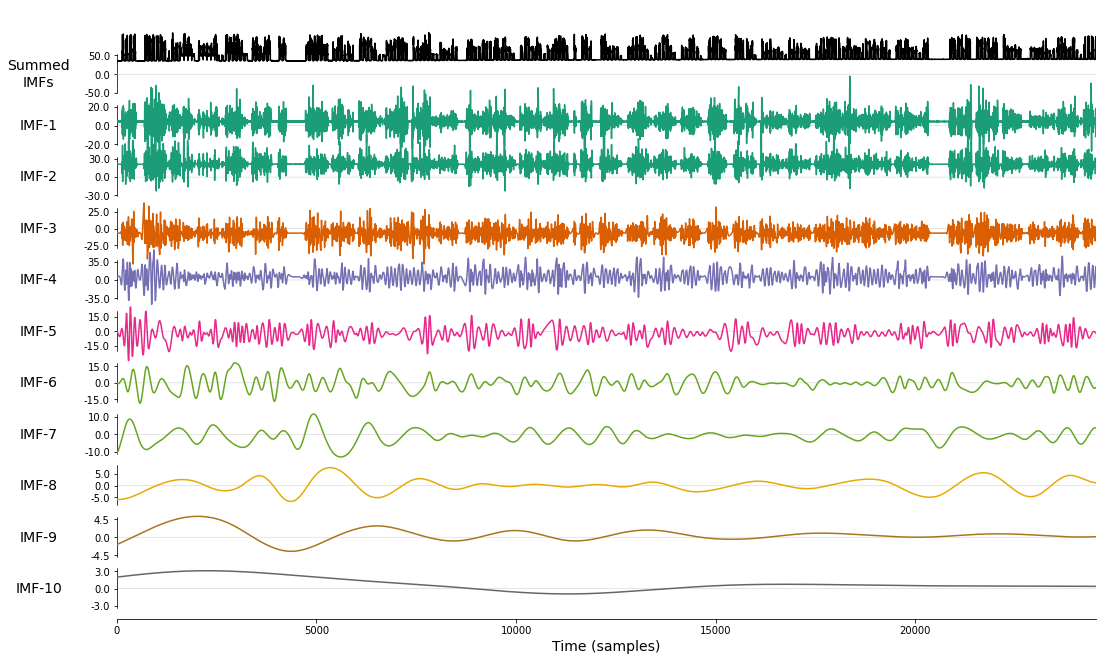

In [7]:
import emd

imf = emd.sift.sift(np.array(train), imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)

In [8]:
#put the imf into dataframe
imf_df = pd.DataFrame(data = imf)
imf_df.columns = ['imf_{}'.format(i+1) for i in range(0, imf.shape[1])]
display(imf_df)

,imf_1,imf_2,imf_3,imf_4,imf_5,imf_6,imf_7,imf_8,imf_9,imf_10
0,-0.410418,0.096734,0.012662,0.266056,4.654688,0.067477,-20.472990,-11.796666,-4.588843,3.082662
1,0.400239,0.121368,-0.002632,0.334189,4.568617,0.017735,-20.403255,-11.799372,-4.579866,3.084406
2,-0.368732,0.130672,-0.013657,0.404290,4.477960,-0.030306,-20.331976,-11.802020,-4.570887,3.086150
3,-0.285557,0.112370,-0.019505,0.475967,4.382699,-0.076631,-20.259160,-11.804611,-4.561904,3.087894
4,0.264102,0.062765,-0.020476,0.548891,4.282814,-0.121229,-20.184814,-11.807144,-4.552917,3.089637
...,...,...,...,...,...,...,...,...,...,...
24523,2.139145,-10.275599,-4.272019,39.139285,1.708957,-7.500440,9.255424,2.328822,-0.622215,-0.109875
24524,2.974048,-9.148159,-9.567093,39.219571,1.639081,-7.438328,9.247855,2.325870,-0.621509,-0.109998
24525,-0.504868,-0.677014,-13.606295,38.962034,1.570491,-7.374875,9.239659,2.322986,-0.620802,-0.110122
24526,-0.003040,6.863818,-15.593641,38.360157,1.503190,-7.310106,9.230840,2.320169,-0.620094,-0.110245


In [9]:
imf1_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_SVR.fit(df_train.values, imf_df['imf_1'])
imf1_SVR_fc = imf1_SVR.predict(np.array(df_test))

In [10]:
imf2_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_SVR.fit(df_train.values, imf_df['imf_2'])
imf2_SVR_fc = imf2_SVR.predict(np.array(df_test))

In [11]:
imf3_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_SVR.fit(df_train.values, imf_df['imf_3'])
imf3_SVR_fc = imf3_SVR.predict(np.array(df_test))

In [12]:
imf4_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_SVR.fit(df_train.values, imf_df['imf_4'])
imf4_SVR_fc = imf4_SVR.predict(np.array(df_test))

In [13]:
imf5_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_SVR.fit(df_train.values, imf_df['imf_5'])
imf5_SVR_fc = imf5_SVR.predict(np.array(df_test))

In [14]:
imf6_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_SVR.fit(df_train.values, imf_df['imf_6'])
imf6_SVR_fc = imf6_SVR.predict(np.array(df_test))

In [ ]:
imf7_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_SVR.fit(df_train.values, imf_df['imf_7'])
imf7_SVR_fc = imf7_SVR.predict(np.array(df_test))

In [ ]:
imf8_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_SVR.fit(df_train.values, imf_df['imf_8'])
imf8_SVR_fc = imf8_SVR.predict(np.array(df_test))

In [ ]:
imf9_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_SVR.fit(df_train.values, imf_df['imf_9'])
imf9_SVR_fc = imf9_SVR.predict(np.array(df_test))

In [ ]:
imf10_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf10_SVR.fit(df_train.values, imf_df['imf_10'])
imf10_SVR_fc = imf10_SVR.predict(np.array(df_test))

In [ ]:
imf_list = ['imf{}_SVR_fc'.format(i) for i in range(1,11)]

imf_fc = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
                imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
                imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc, imf10_SVR_fc], axis = 0)

plt.plot(imf_fc)
plt.plot(test.values)

In [ ]:

plt.plot(imf[:, 10][:100].reshape(-1,1))
plt.plot(np.array(load[:100]))
print(imf[:, 0][:100].reshape(-1,1))

In [ ]:
plt.plot(imf_fc[:200])
plt.plot(test[:200].values)

# BACKLOG

# Simple Moving Average - SVM

In [ ]:
#6 unit
sma = train.rolling(window = 6).mean()
sma.plot()
print(sma)

In [ ]:
param_grid = [
    {'C': [0.5, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']},
]

optimal_params = GridSearchCV(
    SVR(),
    param_grid,
    cv = 5,
    scoring = 'neg_mean_absolute_percentage_error',
    verbose = 0)
optimal_params.fit(df_train.values, arima.resid)
print(optimal_params.best_params_)